# Parse logs gathered from `gather_data.sh` script

This Jupyter notebook parses the `docker ps` output and splits it into digestible graphs.

The only containers that are analyzed are the ones defined in the `CONTAINERS` dictionary below.
Other containers are ignored.

In [26]:
# This dictionary contains a mapping from the pretty name of the container to the name of the container in the logs
CONTAINERS: dict[str, str] = {
    "Data Manager": "edge_data_manager",
    "Edge Broker": "edge_broker",
    "MongoDB": "case2-mongodb-1",
}

From here on, there's a lot of code.

In [6]:
import math
import os
import re
from collections.abc import Callable
from dataclasses import dataclass
from glob import iglob
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Here we're defining a lot of helper functions to facilitate data parsing and analysis. Some of them aren't used anymore.

In [48]:
@dataclass
class MetaFig:
    title: str
    data_keys: list[str]
    xlim: tuple
    ylim: tuple | None = None
    figure: plt.Figure = None
    axes: np.ndarray = None
    fmt: Callable | None = None
    labels: list | None = None
    data_transform: Callable[[pd.Series], pd.Series] | None = None
    replicas: dict[str, tuple[plt.Figure, np.ndarray]] = None

    def data(self, df: pd.DataFrame):
        for key in self.data_keys:
            yield df[key] if self.data_transform is None else df[key].apply(self.data_transform)


def split_on_slash(df_col, split_index):
    return df_col.apply(lambda x: x.split(" / ")[split_index])


def get_only_characters(string):
    return re.sub(r"[^a-zA-Z]+", "", string)


def get_only_numbers(string):
    return float(re.sub(r"[^\d\.]", "", string))


def to_bit(value):
    return int(
        {
            "b": get_only_numbers(value) * 1,
            "kib": get_only_numbers(value) * 8e3,
            "kb": get_only_numbers(value) * 8e3,
            "mib": get_only_numbers(value) * 8e6,
            "mb": get_only_numbers(value) * 8e6,
            "gib": get_only_numbers(value) * 8e9,
            "gb": get_only_numbers(value) * 8e9,
        }.get(get_only_characters(value).lower(), 0)
    )


def from_bit(value: int):
    if value < 8e3:
        return f"{value/8:g} B"
    elif value < 8e6:
        return f"{value/8e3:g} KB"
    elif value < 8e9:
        return f"{value/8e6:g} MB"
    elif value < 8e12:
        return f"{value/8e9:g} GB"
    else:
        return f"{value/8e12:g} TB"


def percentage_to_float(df_col):
    return df_col.apply(lambda x: float(x[0:-1]))


def closest_power_of_2(n):
    return 2 ** math.ceil(math.log(n, 2))


def plot_axis(ax, xlim: tuple, ylim: tuple, fmt, idx, data: Iterable, labels: list | None = None):
    ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    if fmt:
        ax.yaxis.set_major_formatter(fmt)
    if labels:
        for _data, _ in zip(data, labels):
            ax.plot(idx, _data, linewidth=3)
        ax.legend(labels)
    else:
        ax.plot(idx, *data, linewidth=3)

In [49]:
NET_IO_COL = "NET I/O"

dfs = {}
for fname in iglob("../Case 2/logs/logs/*.csv"):
    if fname in ("logs_200.csv", "logs_300.csv", "logs_500.csv"):
        continue

    df = pd.read_csv(fname, delimiter=r"\s\s+", engine="python")

    df = df[df[NET_IO_COL] != NET_IO_COL]

    df["mem_percentage"] = percentage_to_float(df["MEM %"])
    df["cpu_percentage"] = percentage_to_float(df["CPU %"])
    df["mem_usage_bits"] = df["MEM USAGE / LIMIT"].apply(lambda x: to_bit(x[: x.find("/") - 1]))
    df[["net_input_bits", "net_output_bits"]] = df[NET_IO_COL].apply(
        lambda x: pd.Series(map(to_bit, map(str.strip, x.split("/"))))
    )
    df = df.drop(["CONTAINER ID", "CPU %", "MEM USAGE / LIMIT", "MEM %", NET_IO_COL, "PIDS", "BLOCK I/O"], axis=1)
    dfs[int(fname[fname.rfind('_')+1:fname.rfind('.')])] = df
    

Get the maximum values for each category in our dataset:

In [50]:
containers = list(CONTAINERS.values())
container_nice_names = list(CONTAINERS.keys())

max_val_mem = max(max(df.loc[df["NAME"].isin(containers)].mem_percentage) for df in dfs.values())
max_val_cpu = max(max(df.loc[df["NAME"].isin(containers)].cpu_percentage) for df in dfs.values())
max_val_net = max(
    max(
        max(df.loc[df["NAME"].isin(containers)].net_input_bits),
        max(df.loc[df["NAME"].isin(containers)].net_output_bits),
    )
    for df in dfs.values()
)
max_val_mem_bits = max(max(df.loc[df["NAME"].isin(containers)].mem_usage_bits) for df in dfs.values())

plt.style.use('ggplot')

## Create and configure the figures and data formats

This cell creates a list of "meta figures", i.e. structures that will contain everything needed to render our plots correctly given each of the categories' rules (e.g. a specific formatter, different x/y limits, etc).
We define three meta figures: Network I/O, CPU Usage %, and Memory Usage %.
Each `MetaFig` object is able to correctly read and plot the data in our dataset given its specific configuration.

Other meta figures can be created programatically simply by adding another entry to this list - the rest of the script will adapt to the new size accordingly.

In [56]:
axfmts = [
    MetaFig(title="Memory Usage",
            xlim=(0, 120),
            ylim=(0, closest_power_of_2(max_val_mem_bits)),
            data_keys=["mem_usage_bits"],
        #     data_transform=(lambda x: x / 1e6),
            fmt=(lambda x, _: from_bit(int(x)))),
    MetaFig(title="Network I/O",
            xlim=(0, 120), 
            ylim=(-0.5, closest_power_of_2(max_val_net / 8e6)), 
            data_keys=["net_input_bits", "net_output_bits"], 
            data_transform=(lambda x: x / (8e6)),
            labels=['input (MB)', 'output (MB)']),
    MetaFig(title="CPU Usage %",
            xlim=(0, 120),
            ylim=(-1, closest_power_of_2(max_val_cpu)),
            data_keys=["cpu_percentage"],
            fmt=(lambda x, _: f'{int(x)}%')),
    MetaFig(title="Memory Usage %",
            xlim=(0, 120),
            ylim=(0.15, closest_power_of_2(max_val_mem)),
            data_keys=["mem_percentage"],
            fmt=(lambda x, _: f'{int(x*100)/100}%')),
]

Plot the data:

/tmp/ipykernel_31008/3776023587.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=len(containers), ncols=len(dfs), figsize=(3 * len(dfs), 8))


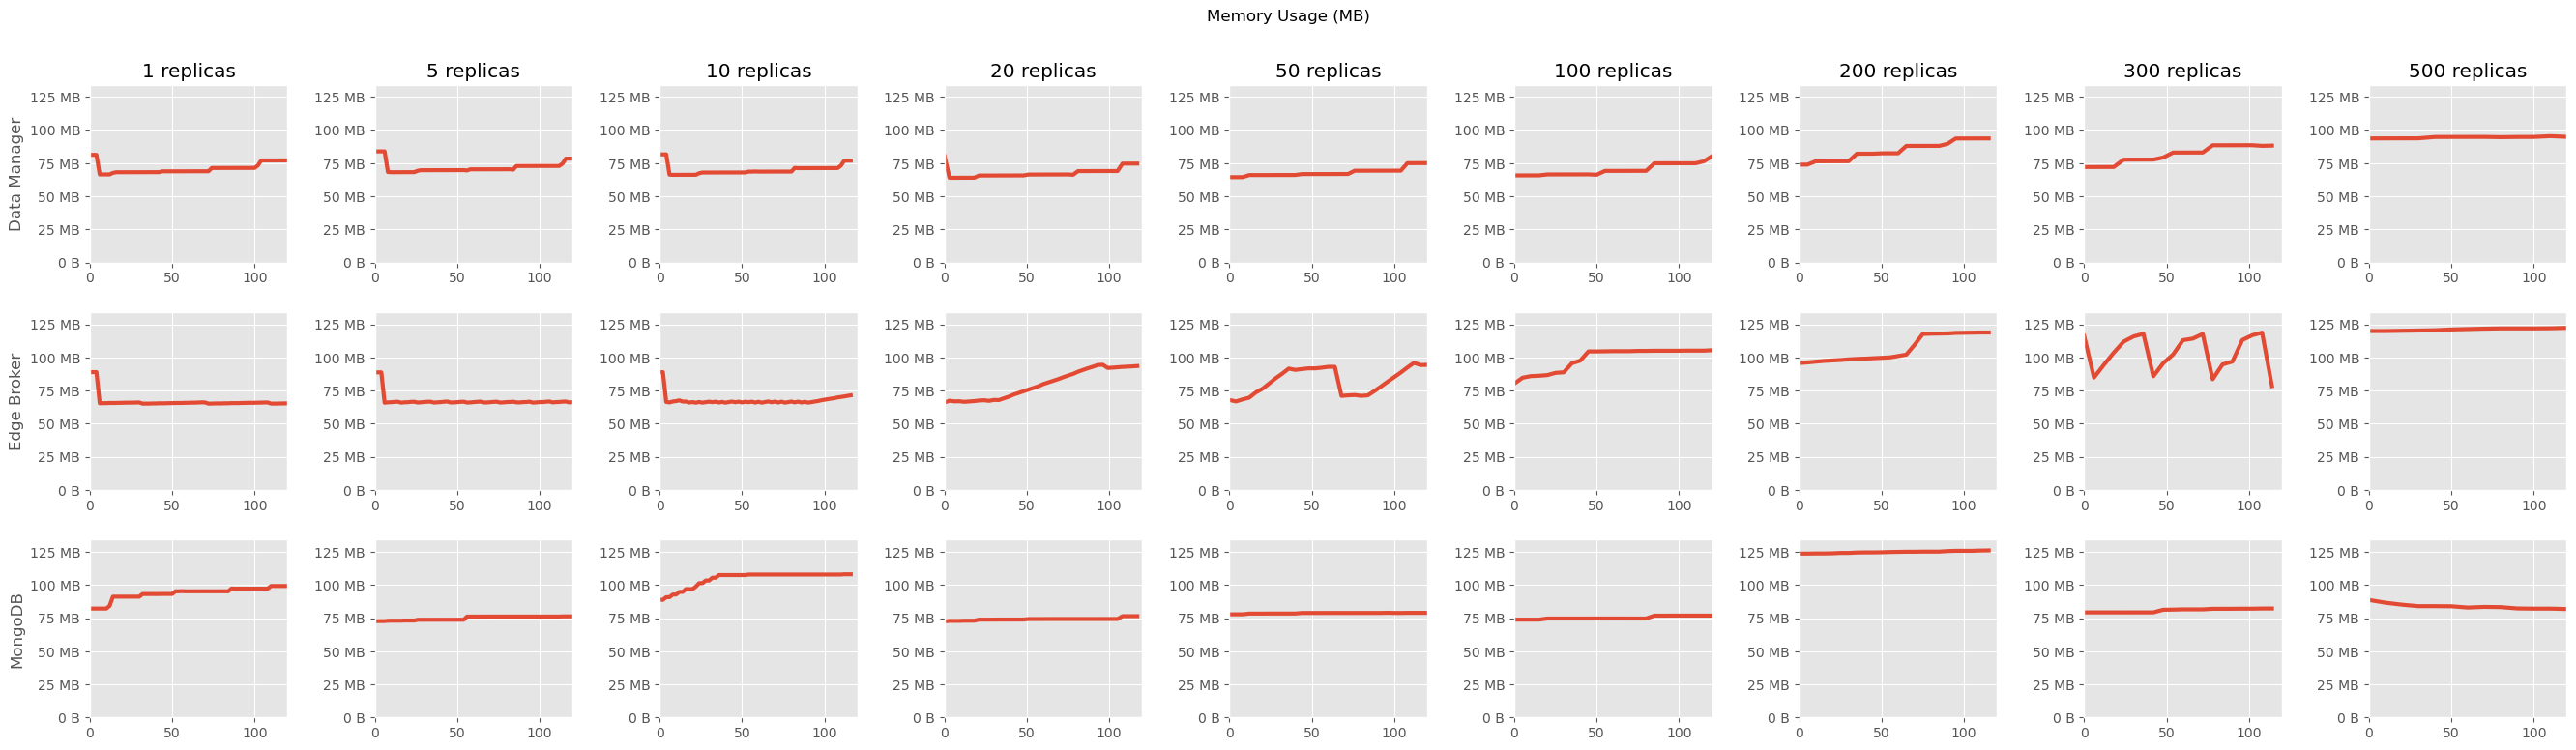

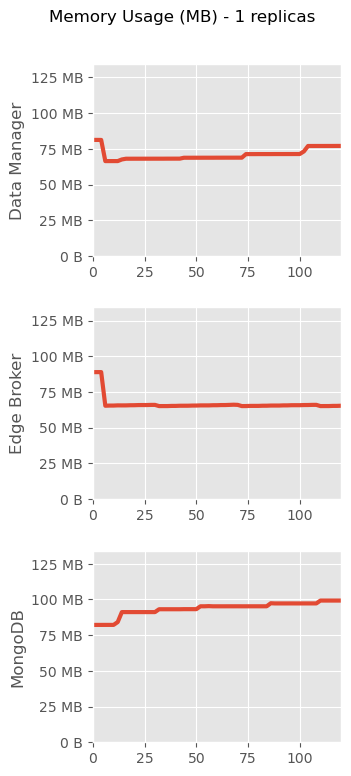

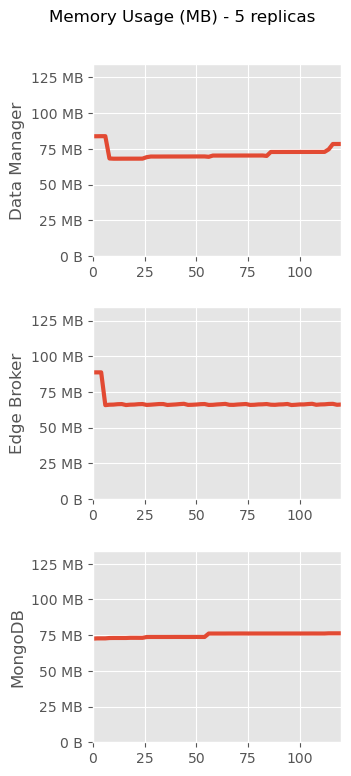

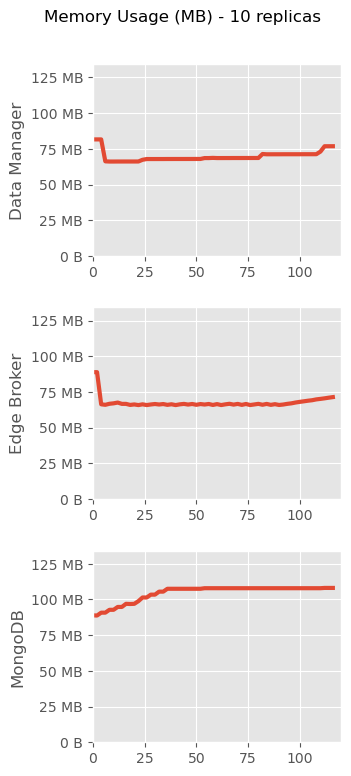

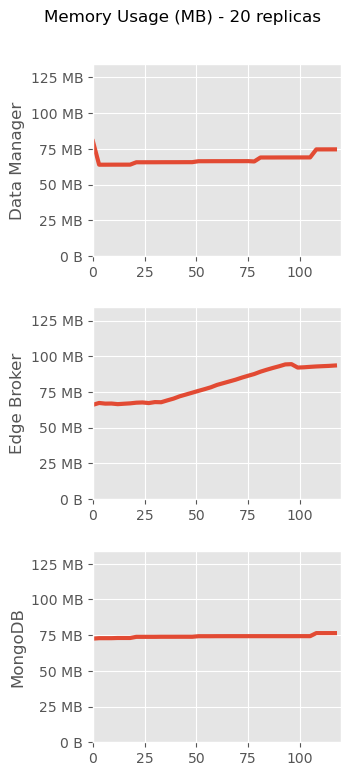

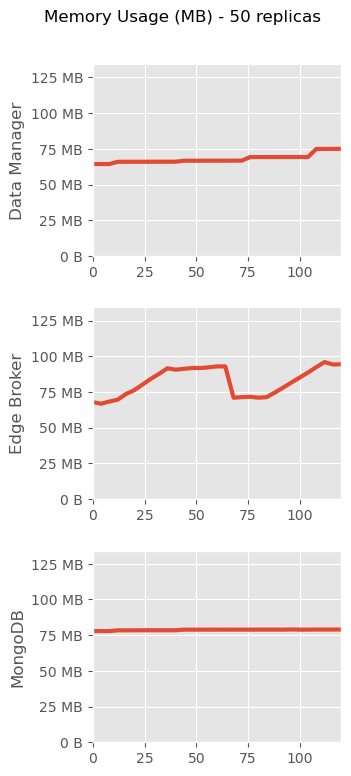

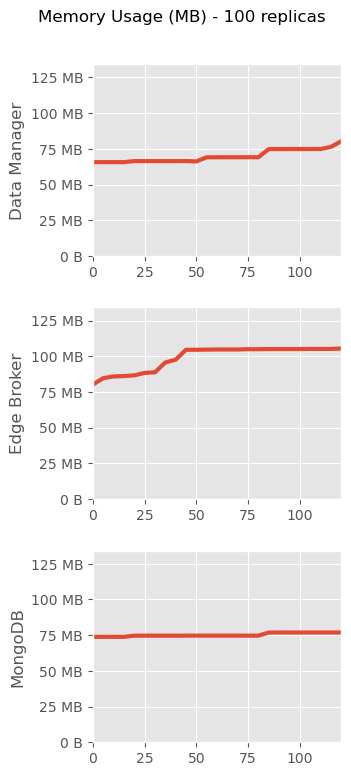

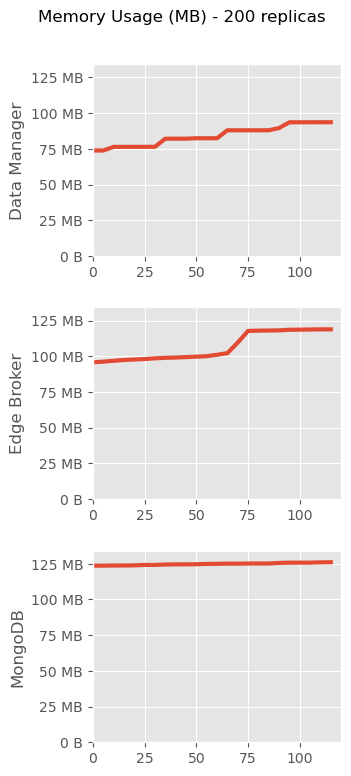

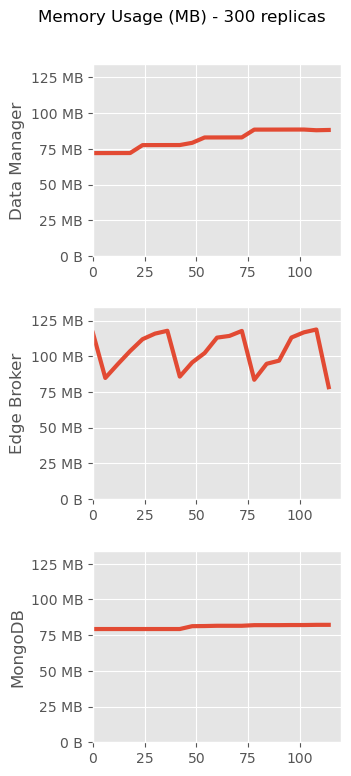

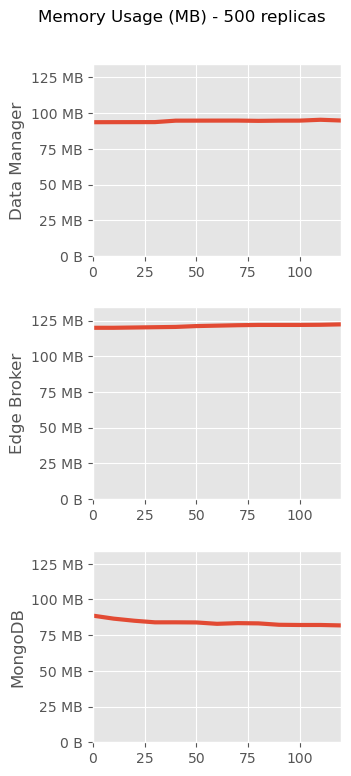

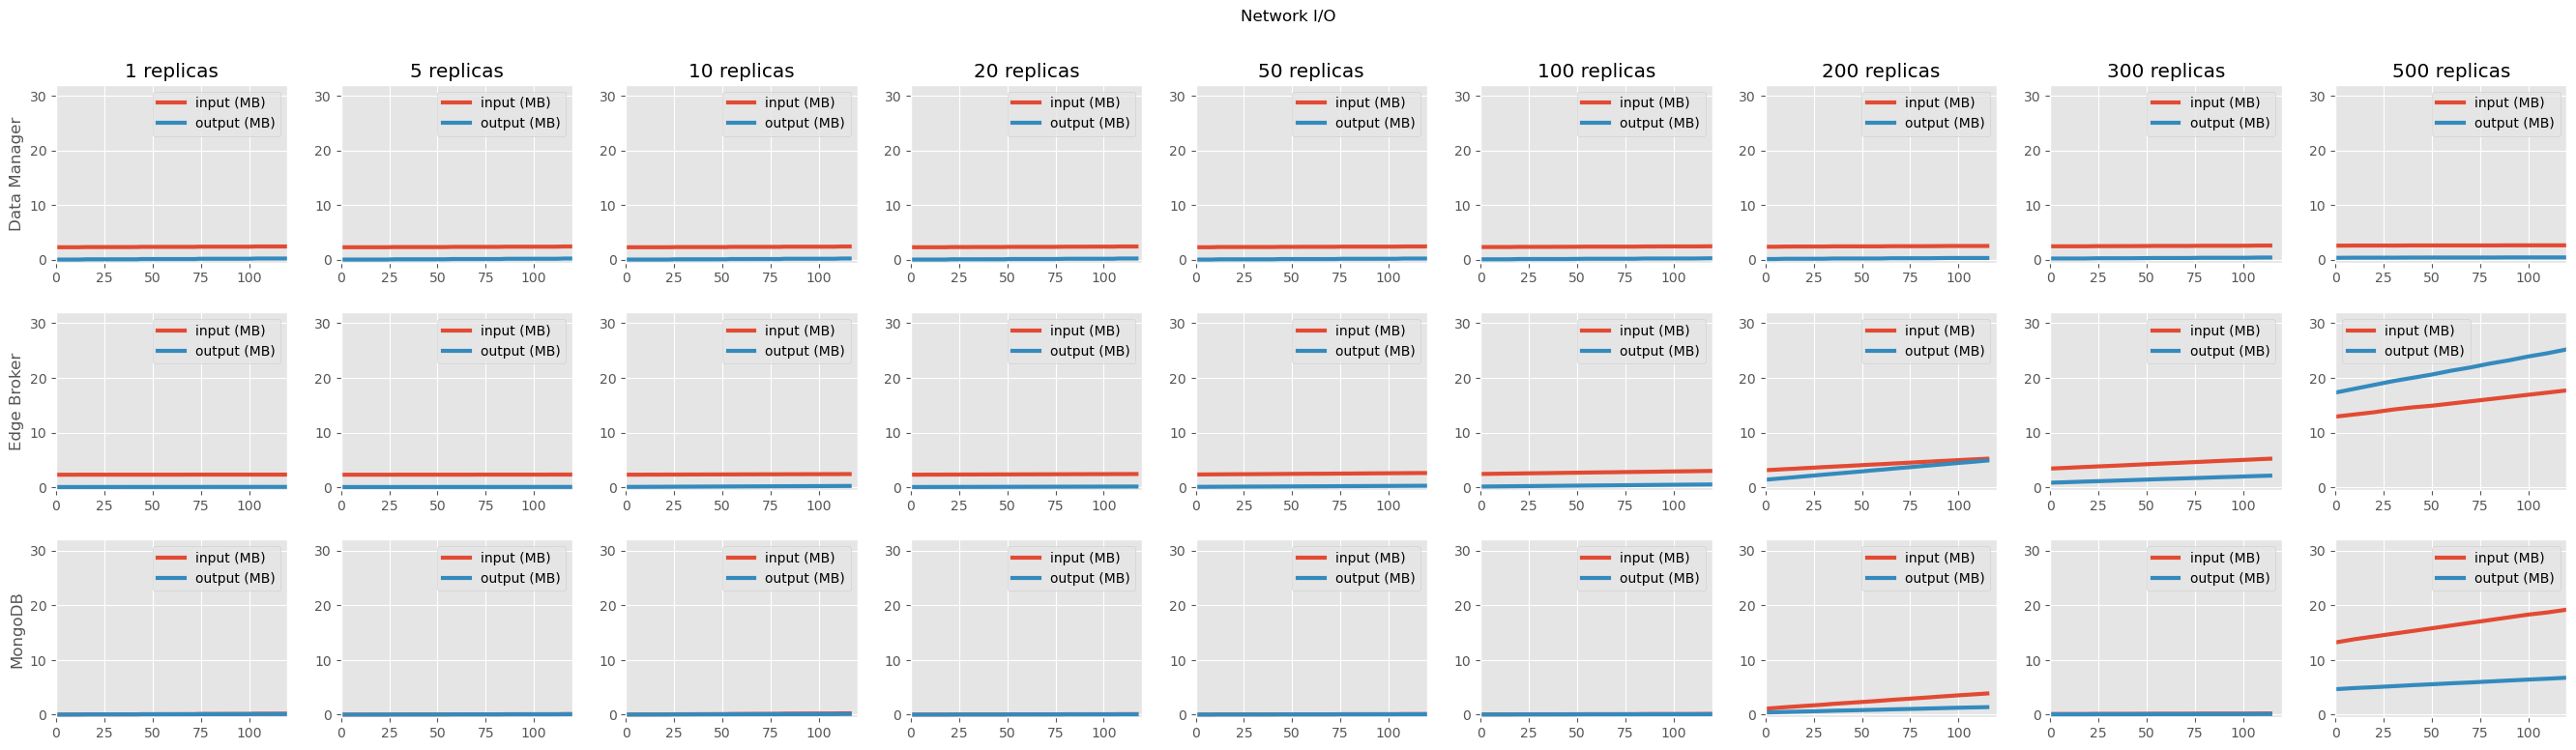

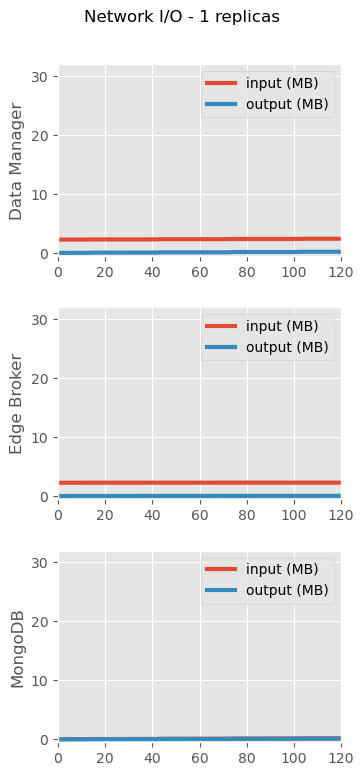

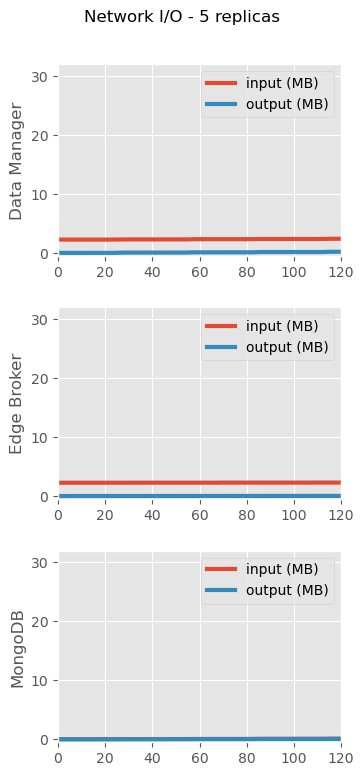

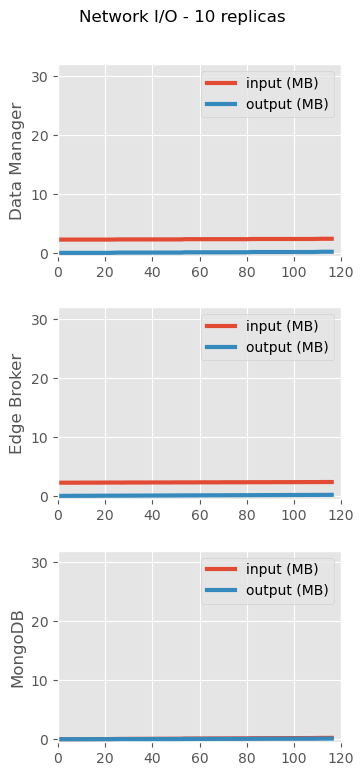

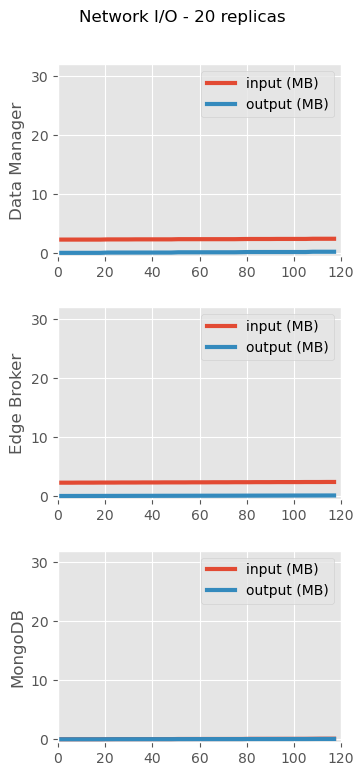

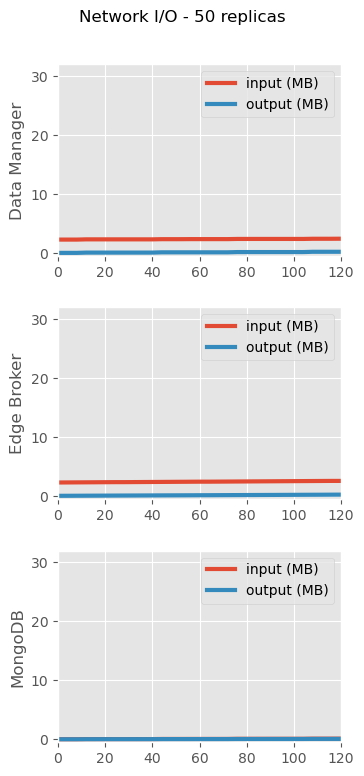

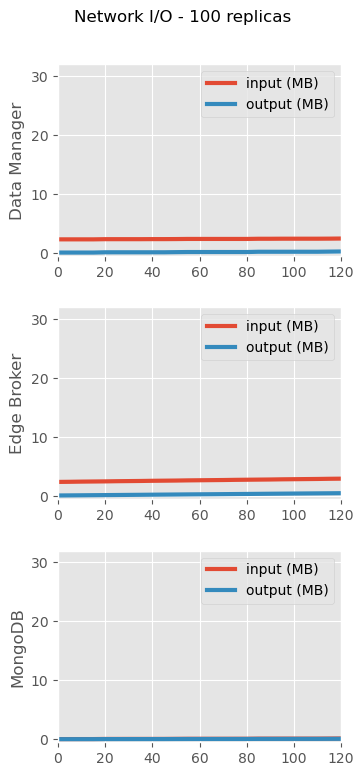

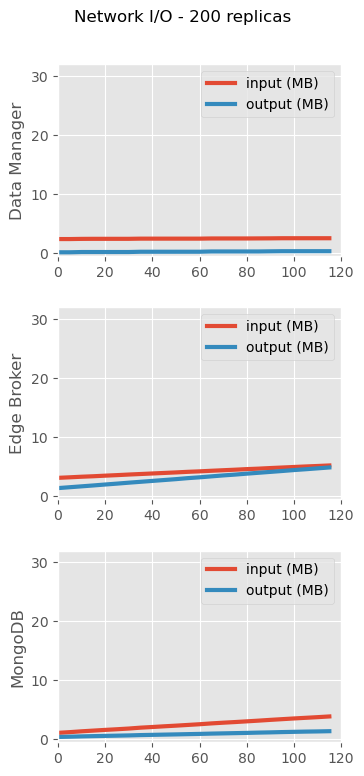

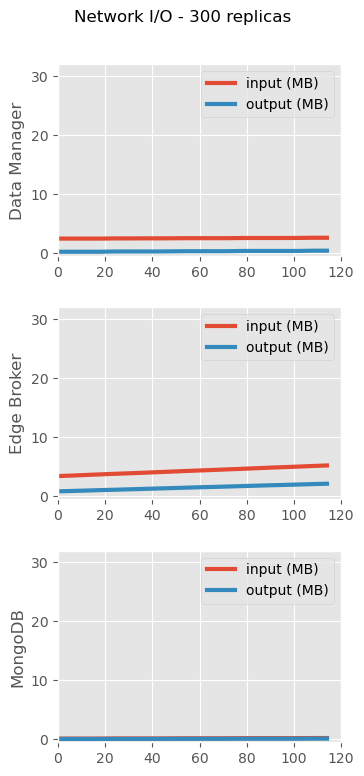

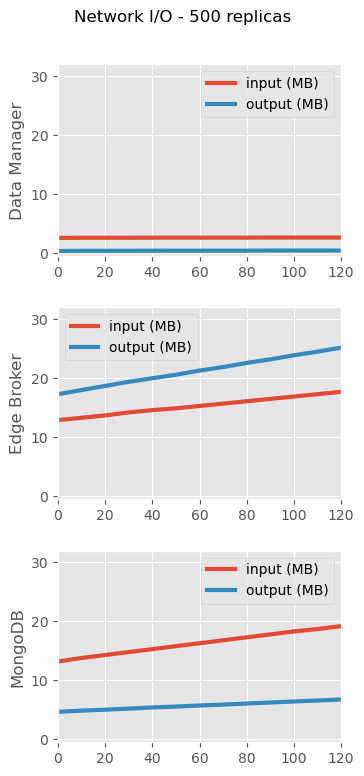

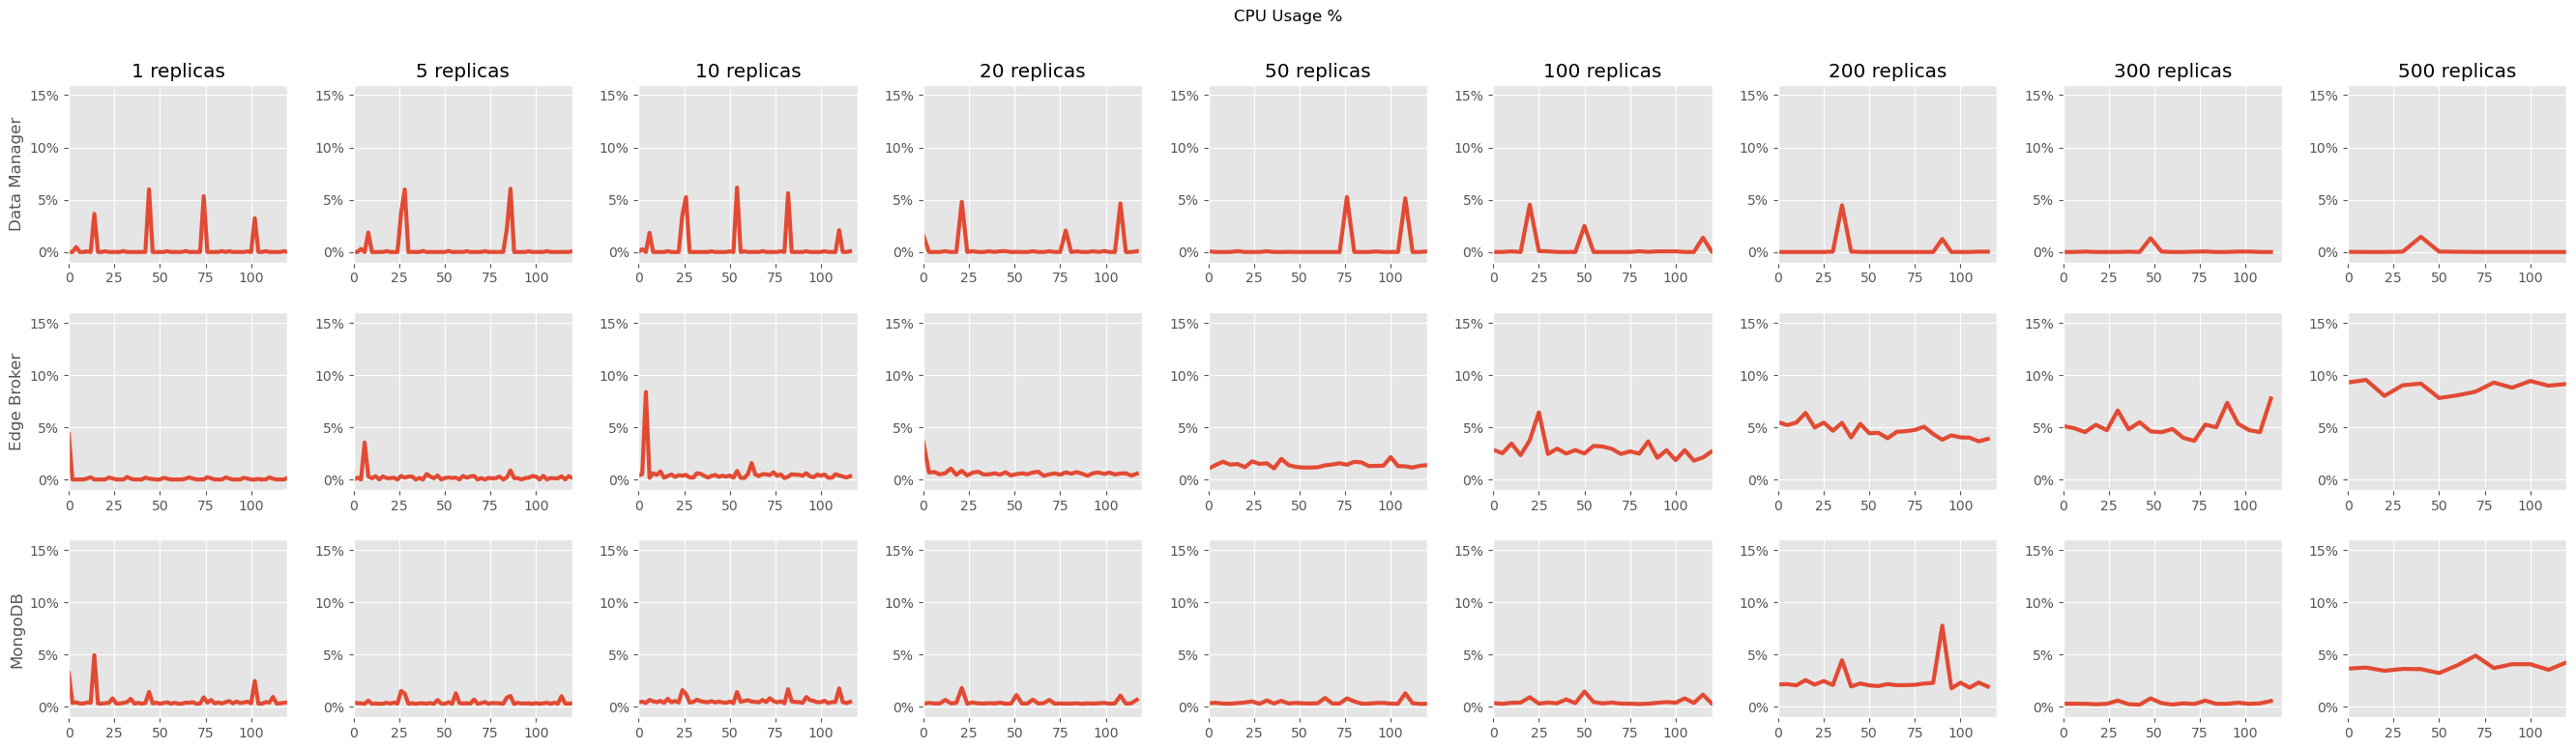

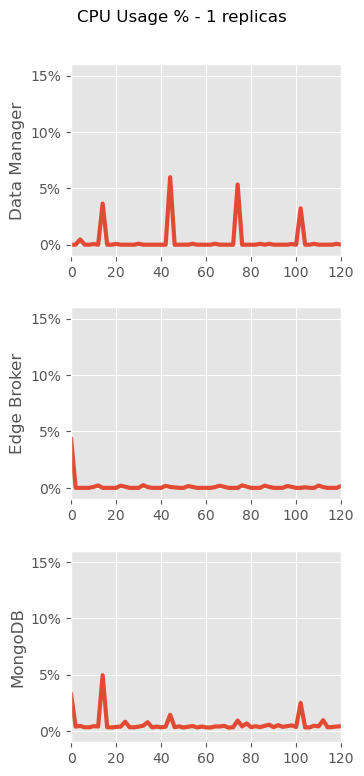

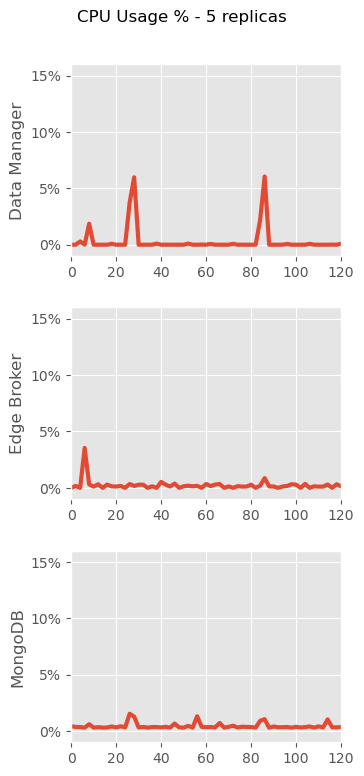

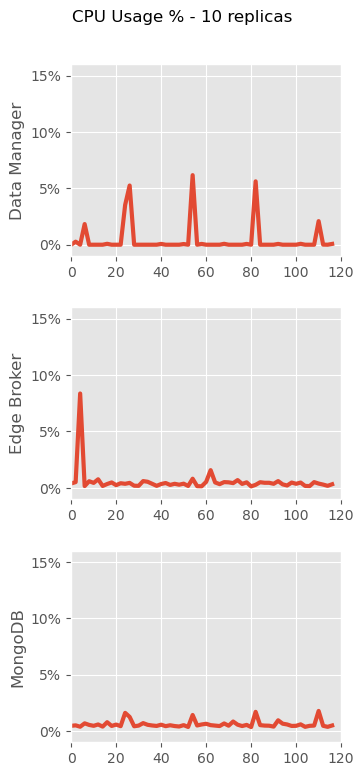

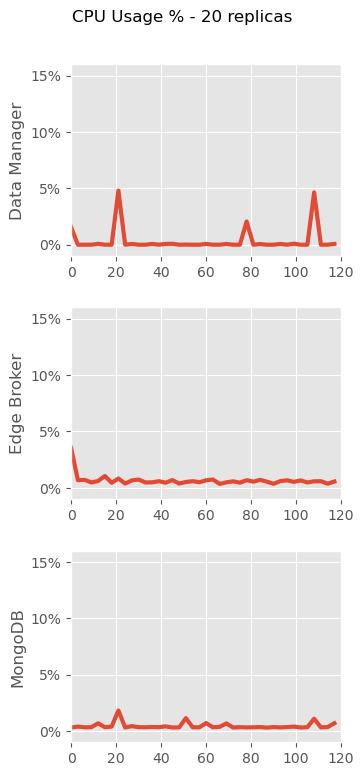

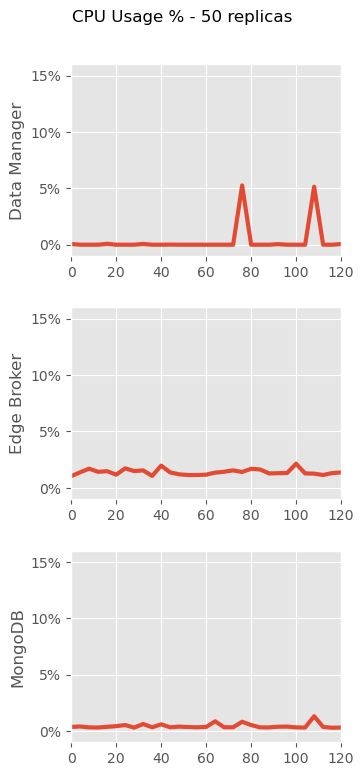

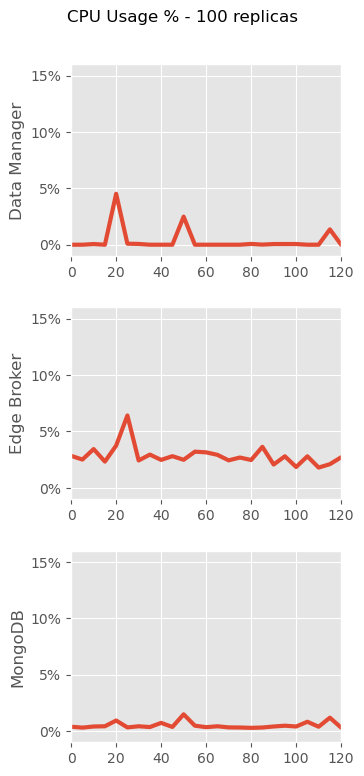

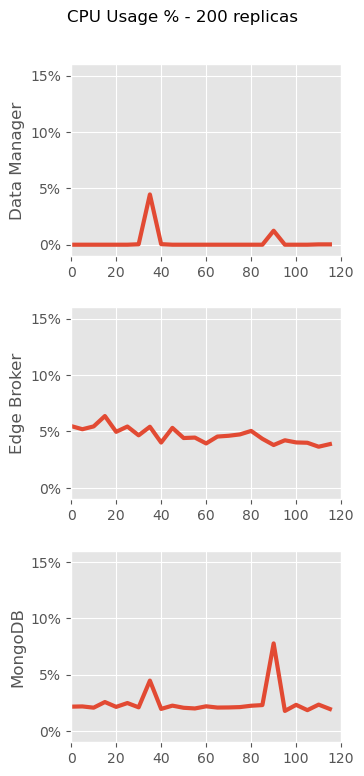

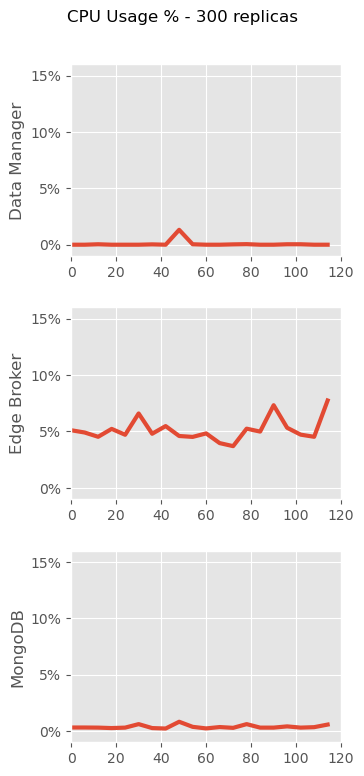

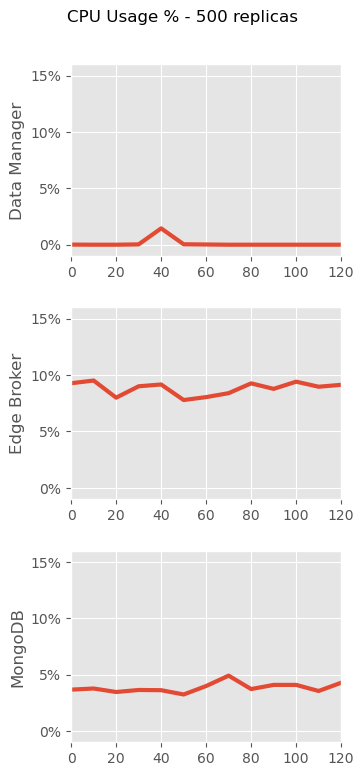

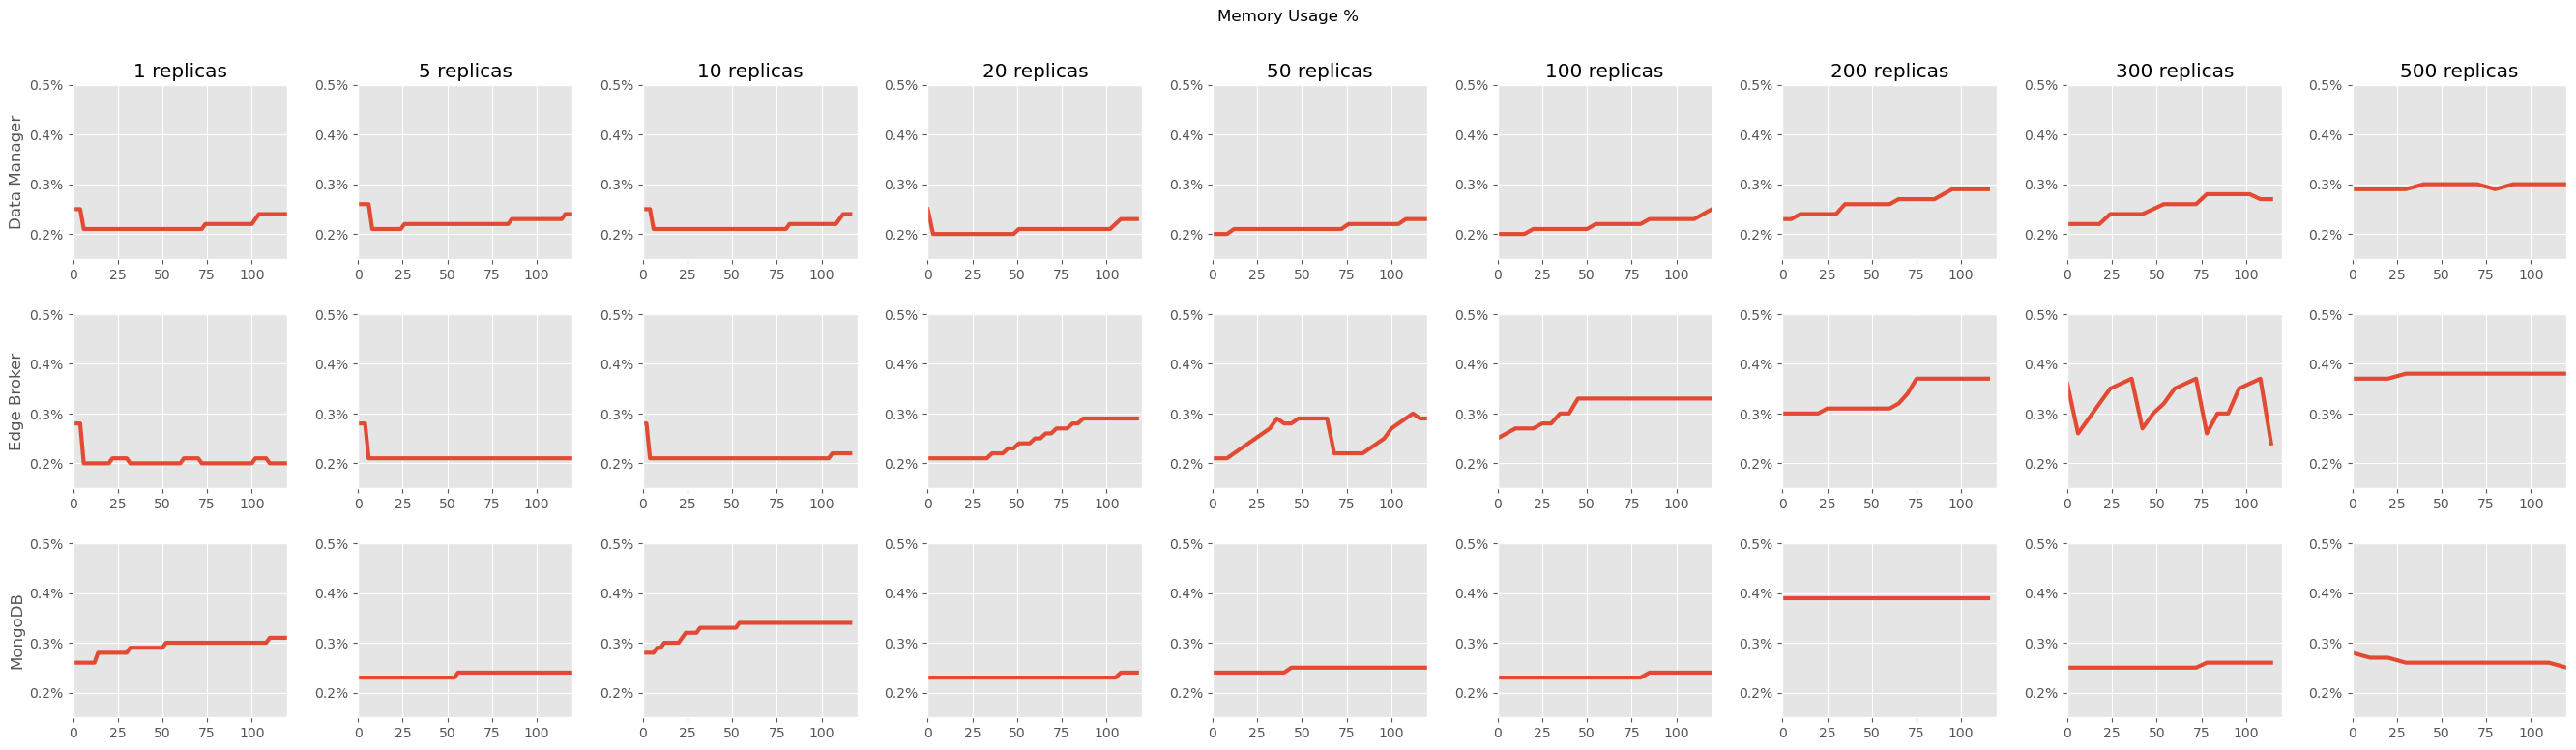

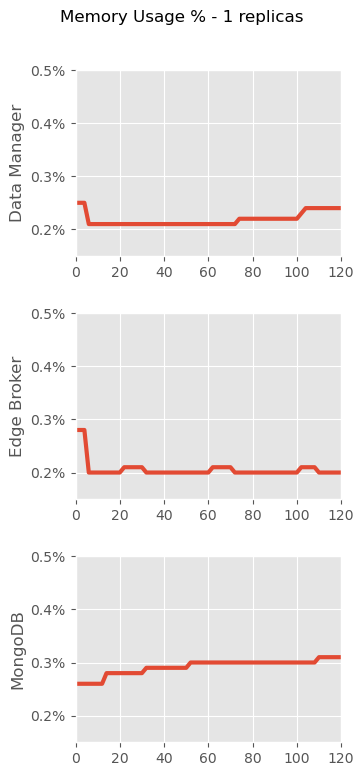

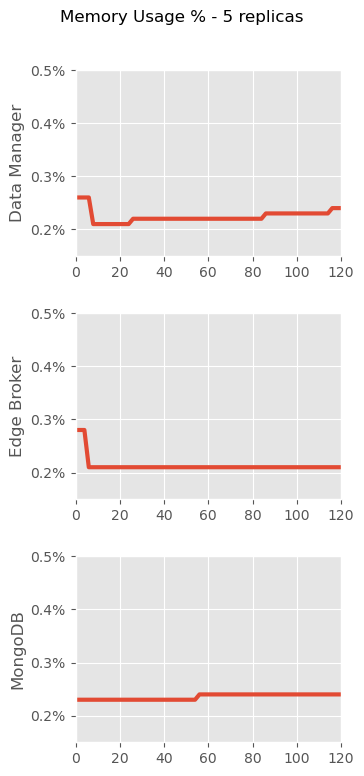

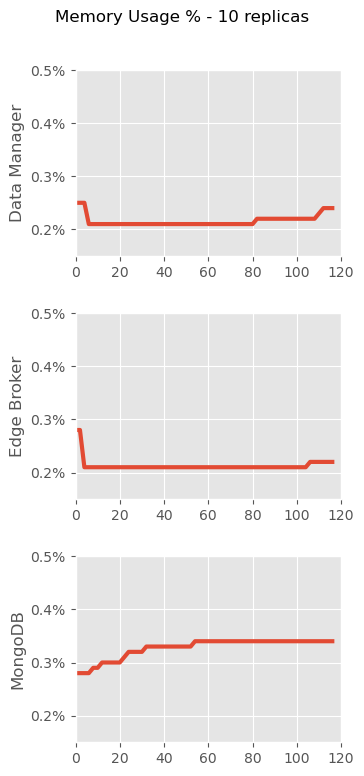

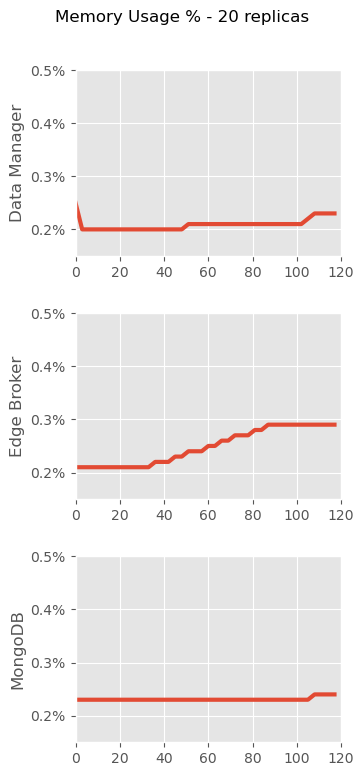

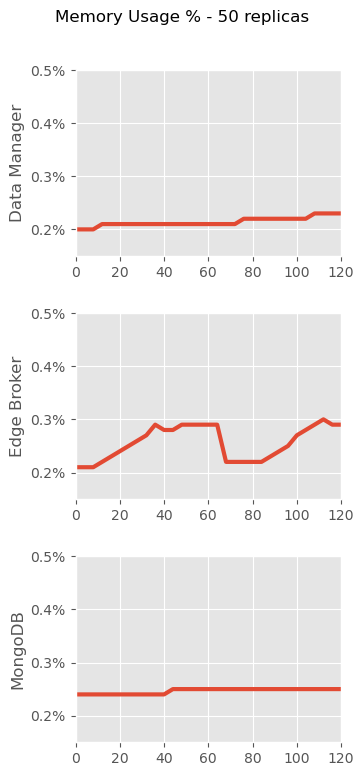

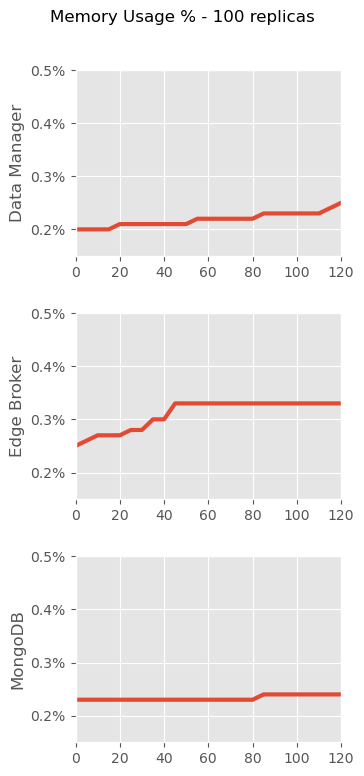

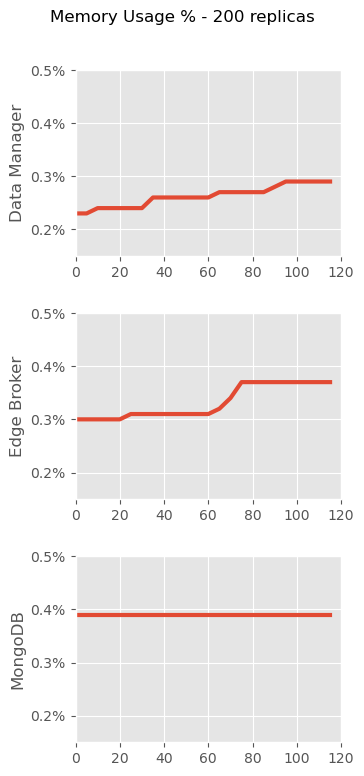

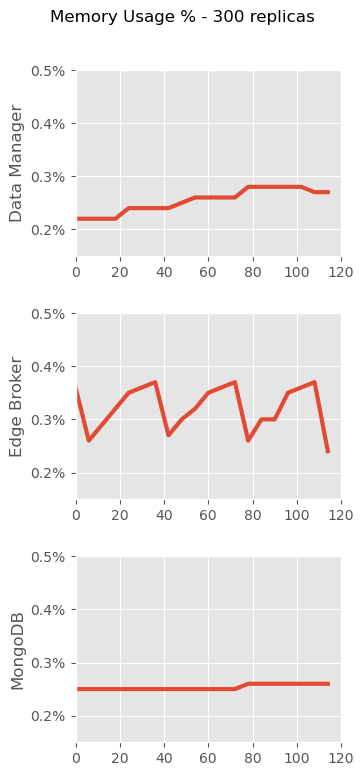

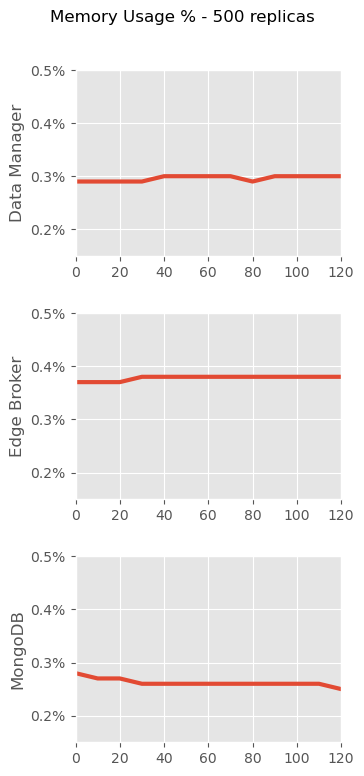

In [57]:
# Create subplots
for axfmt in axfmts:
    fig, axes = plt.subplots(nrows=len(containers), ncols=len(dfs), figsize=(3 * len(dfs), 8))
    axfmt.figure = fig
    axfmt.axes = axes
    axfmt.replicas = {replica: plt.subplots(nrows=len(containers), ncols=1, figsize=(4, 8)) for replica in sorted(dfs.keys())}

# Plot data
for i, container in enumerate(containers):
    for j, replicas_amount in enumerate(sorted(dfs.keys())):
        df = dfs[replicas_amount]

        edm = df.loc[df["NAME"] == container].copy()
        edm['time'] = pd.timedelta_range(start='0 seconds', periods=len(edm), freq=f'{round(125 / len(edm))}S')
        edm.set_index("time", inplace=True)
        edm = edm.drop(["NAME"], axis=1)

        for axfmt in axfmts:
            for ax in (axfmt.axes[i][j], axfmt.replicas[replicas_amount][1][i]):
                plot_axis(ax, axfmt.xlim, axfmt.ylim, axfmt.fmt, edm.index.seconds, axfmt.data(edm), axfmt.labels)

# Set labels and titles and layouts
for axfmt in axfmts:
    axes = axfmt.axes
    for ax, col in zip(axes[0], sorted(dfs.keys())):
        ax.set_title(f'{col} replicas')

    for ax, row in zip(axes[:, 0], container_nice_names):
        ax.set_ylabel(row, rotation=90, size='large')

    fig = axfmt.figure
    fig.suptitle(axfmt.title)
    fig.tight_layout(pad=2)

    for replica, (fig, axes) in axfmt.replicas.items():
        for ax, row in zip(axes, container_nice_names):
            ax.set_ylabel(row, rotation=90, size='large')
        fig.suptitle(f'{axfmt.title} - {replica} replicas')
        fig.tight_layout(pad=2)


Save figures to disk in their respective folders.

In [58]:
[os.makedirs(f'img/{replica}/{fmt}', exist_ok=True) for replica in (list(dfs.keys()) + ['all']) for fmt in ('svg', 'png')]
for axfmt in axfmts:
    fig = axfmt.figure

    filename = ''.join(filter((lambda c: (96 < ord(c) <= 122) or ord(c) == 32), axfmt.title.lower())).replace(' ', '_')

    for fmt in ('svg', 'png'):
        path = f'img/all/{fmt}'
        fig.savefig(fname=f'{path}/{filename}.{fmt}')

    for replica, (fig, _) in axfmt.replicas.items():
        for fmt in ('svg', 'png'):
            path = f'img/{replica}/{fmt}'
            fig.savefig(fname=f'{path}/{filename}.{fmt}')